In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base =automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement =Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)
session

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x16875ba3f88>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'id': 1}

In [10]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x16875bd2ec8>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

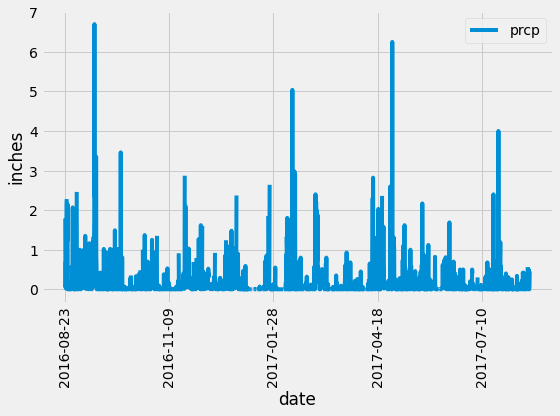

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

last_date = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()[0]
#last_date

entry_date=dt.datetime.strptime(last_date,'%Y-%m-%d' )

entry_date=entry_date.date()

# Calculate the date one year from the last date in data set.

yr_ago = entry_date - dt.timedelta(days=365)
yr_ago

# Perform a query to retrieve the data and precipitation scores

one_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yr_ago).\
    filter(Measurement.date <= last_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(one_year_prcp, columns=['date','prcp'])
df.set_index('date', inplace=True)


# Sort the dataframe by date
new_df=df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data

new_df.plot(figsize=(8,6))

plt.xticks(rotation=90)
plt.ylabel('inches')
plt.savefig('precipitation.png')
plt.tight_layout()
plt.show()


In [15]:
df.dtypes


prcp    float64
dtype: object

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
station_count=session.query(Measurement.station).count()
print(f'station count is:',station_count)

station_count1=session.query(Measurement.station).distinct().count()
print(f'distinct station count is :',station_count1)


station count is: 19550
distinct station count is : 9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Data Count'])
active_stations_df



,Station,Data Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]

sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

most_active_station_tobs = session.query(*sel).\
    filter(Measurement.station==most_active).all()[0]

print(f"Temperature Minimum: {most_active_station_tobs[0]}")
print(f"Temperature Average: {most_active_station_tobs[1]}")
print(f"Temperature Maximum: {most_active_station_tobs[2]}")


Temperature Minimum: 54.0
Temperature Average: 71.66378066378067
Temperature Maximum: 85.0


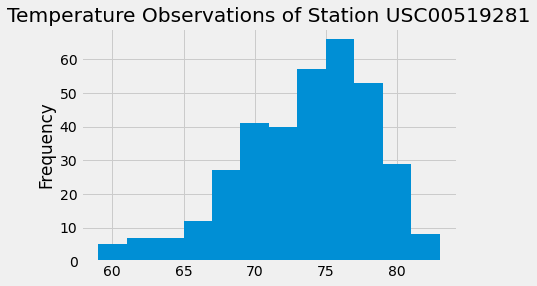

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stn_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= yr_ago).\
    filter(Measurement.date <= last_date).\
    filter(Measurement.station==most_active).all()

tobs_array = np.ravel(stn_tobs)
tobs_series = pd.Series(tobs_array)

tobs_series.plot.hist(bins=12)
plt.title("Temperature Observations of Station USC00519281")
plt.savefig('station-histogram.png')
plt.show()

# Close session

In [18]:
# Close Session
session.close()